# A step-by-step example

In this tutorial we will showcase the ability of ``flowMC`` to sample efficiently a 5-dimensional multi-modal distribution. We will go through the typical steps of verification one follows to confirm the quality of the samples at the end of the MCMC run. 

This is a simple example of a 5-dimensional multi-modal distribution:


![Dual Moon](docs/dual_moon.png)


## 1 - The target distribution

The first step is to define the target distribution using `jax`. The target distribution should be a function conforming to the following function signature (using `jaxtyping` convention for type hints):

```python
def target_log_prob_fn(x: Float[Array, "n_dims"], data: dict[str, Any]) -> Float:
    ...
    return log_prob
```

`flowMC` will handle batching and compiling the function, so you simply have to provide the version of the function which is evaluated on a specific point in the sample space `X`. `data` represents any additional data that is needed to evaluate the target but not sampled. Note that `data` should remain fixed at run time.

Here below we define our target function:

In [1]:
import jax
import jax.numpy as jnp
from jax.scipy.special import logsumexp
from jaxtyping import Float, Array
from typing import Any


def target_dual_moon(x: Float[Array, "n_dims"], data: dict[str, Any]) -> Float:
    """
    Term 2 and 3 separate the distribution and smear it along the first and second dimension
    """
    term1 = 0.5 * ((jnp.linalg.norm(x) - 2) / 0.1) ** 2
    term2 = -0.5 * ((x[:1] + jnp.array([-3.0, 3.0])) / 0.8) ** 2
    term3 = -0.5 * ((x[1:2] + jnp.array([-3.0, 3.0])) / 0.6) ** 2
    return -(term1 - logsumexp(term2) - logsumexp(term3))


n_dims = 5
data = {"data": jnp.arange(n_dims).astype(jnp.float32)}

# Testing evaluation
x = jnp.zeros(n_dims)
print("Testing the value of the target function at x=0: ", target_dual_moon(x, data))

Testing the value of the target function at x=0:  -218.14496


## 2 - Choosing the sampling resources and strategies

The next step is to initialize the resources and strategies for the MCMC run. The default `flowMC` algorithm that involves a local proposal with MALA and a global proposal with normalizing flows is conveniently packaged in a bundle which the users only have to set its hyper-parameters instead of making sure the internal components are compatible. Here we will import the bundle and initialize it. In the quicks start, there is a detailed explanation of the resource-startegy interface.

In [2]:
from flowMC.resource_strategy_bundles import RQSpline_MALA_Bundle

# Defining hyperparameters

n_local_steps = 100
n_global_steps = 10
n_training_loops = 20
n_production_loops = 20
n_epochs = 5
n_chains = 20
rq_spline_hidden_units = [32, 32]
rq_spline_n_bins = 8
rq_spline_n_layers = 4
learning_rate = 5e-3
batch_size = 5000
n_max_examples = 5000

# Initializing the default flowMC algorithm with RQSpline_MALA_Bundle

rng_key = jax.random.PRNGKey(42)
rng_key, subkey = jax.random.split(rng_key)
bundle = RQSpline_MALA_Bundle(
    subkey,
    n_chains,
    n_dims,
    target_dual_moon,
    n_local_steps,
    n_global_steps,
    n_training_loops,
    n_production_loops,
    n_epochs,
    rq_spline_hidden_units=rq_spline_hidden_units,
    rq_spline_n_bins=rq_spline_n_bins,
    rq_spline_n_layers=rq_spline_n_layers,
    learning_rate=learning_rate,
    batch_size=batch_size,
    n_max_examples=n_max_examples,
    verbose=False,
)

## 3 - Defining and Running the sampler

Now we have defined our resources and strategies, we can pass it to `flowMC` top-level manager, the `Sampler` class to run the MCMC.

In [3]:
from flowMC.Sampler import Sampler

rng_key, subkey = jax.random.split(rng_key)
initial_position = jax.random.normal(subkey, shape=(n_chains, n_dims)) * 1

sampler = Sampler(
    n_dims,
    n_chains,
    rng_key,
    resource_strategy_bundles=bundle,
)

sampler.sample(initial_position, data)

Resources or strategies not provided. Using resource strategy bundles.


Tuning Phase:   0%|          | 0/20 [00:00<?, ?it/s]

Compiling MALA body


Sampling Phase:   0%|          | 0/20 [00:00<?, ?it/s]

Compiling MALA body


Sampling Phase: 100%|██████████| 20/20 [00:16<00:00,  1.18it/s]


## 4 - Inspecting the results

Now the sampling is done, let's check some of the results. The first step is to check what type of buffers are available:

In [4]:
for key, resource in sampler.resources.items():
    print(resource)

Buffer positions_training with shape (20, 2200, 5)
Buffer log_prob_training with shape (20, 2200, 1)
Buffer local_accs_training with shape (20, 2200, 1)
Buffer global_accs_training with shape (20, 2200, 1)
Buffer loss_buffer with shape (1, 100, 1)
Buffer positions_production with shape (20, 2200, 5)
Buffer log_prob_production with shape (20, 2200, 1)
Buffer local_accs_production with shape (20, 2200, 1)
Buffer global_accs_production with shape (20, 2200, 1)
MALA with step size 0.1
NF proposal with MaskedCouplingRQSpline with n_features=5, n_layers=2
MaskedCouplingRQSpline with n_features=5, n_layers=2
Optimizer


We can see there are a number of buffers that store the information about the run, along with some resources like MALA and NF proposal. There are two sets of buffers, one for results during the training phase and the other for the production phase. For each of the phase, there are `position`, `log_prob`, `local_accs` and `global_accs`, which corresponds to the chains, the log-probabilities, whether the proposals were accepted by the local or global proposal. In the training phase, there is an additional buffer `loss_buffer` which stores the loss of the normalizing flow during training. Let's start with inspecting the loss during the training.

Text(0, 0.5, 'Loss')

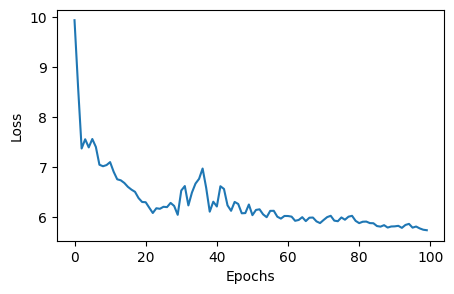

In [5]:
import matplotlib.pyplot as plt

loss_data = sampler.resources["loss_buffer"].data
plt.figure(figsize=(5, 3))
plt.plot(loss_data.reshape(-1, 1))
plt.xlabel("Epochs")
plt.ylabel("Loss")

Loss goes down, looking good! Now let's plot the chains and have a look of the samples. There are a number of visualization tools like [`corner`](https://corner.readthedocs.io/en/latest/) and [`arviz`](https://arviz-devs.github.io/arviz/) that can be used to visualize the samples. Here we will use `corner` to plot the samples generated from `flowMC`, as well as samples from the trained normalizing flow.

<div class="alert alert-block alert-info">
<b>Note:</b>
If you want to run the following cells with `corner` or `arviz`, you have to run `uv sync --extra visualize` to install the dependencies in your `uv` environment.
</div>

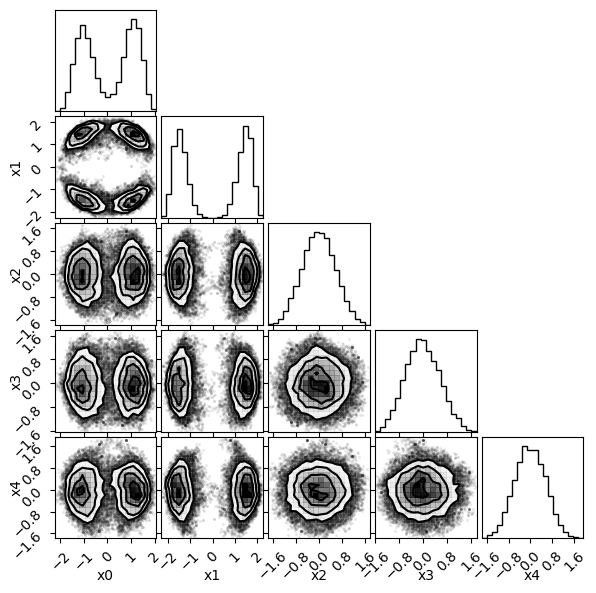

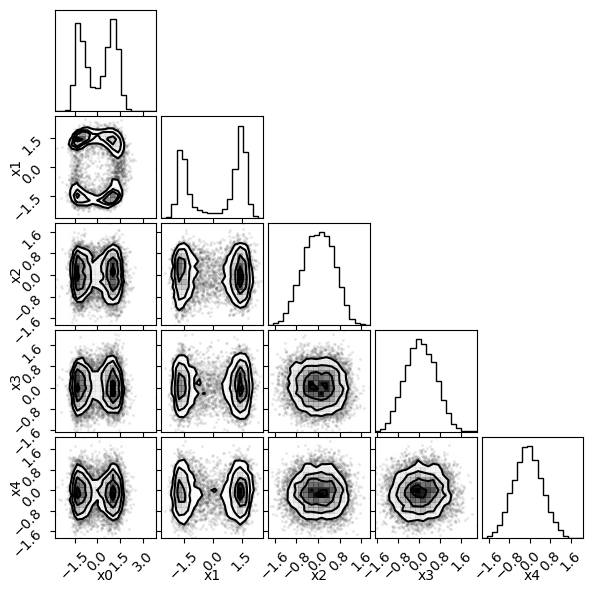

In [6]:
import corner
import numpy as np

chains = sampler.resources["positions_production"].data
nf_samples = sampler.resources["model"].sample(jax.random.PRNGKey(2046), 10000)

labels = [f"x{i}" for i in range(n_dims)]

# Plotting chain from flowMC
fig = plt.figure(figsize=(6, 6))
fig = corner.corner(np.array(chains.reshape(-1, n_dims)), fig=fig, labels=labels)

# Plotting samples from the normalizing flow
fig = plt.figure(figsize=(6, 6))
fig = corner.corner(np.array(nf_samples), fig=fig, labels=labels)

There is our posterior! Now let's also look at some diagnostics, such as the mean acceptance rate and the trace during the production phase.

Text(0.5, 1.0, 'Log probability')

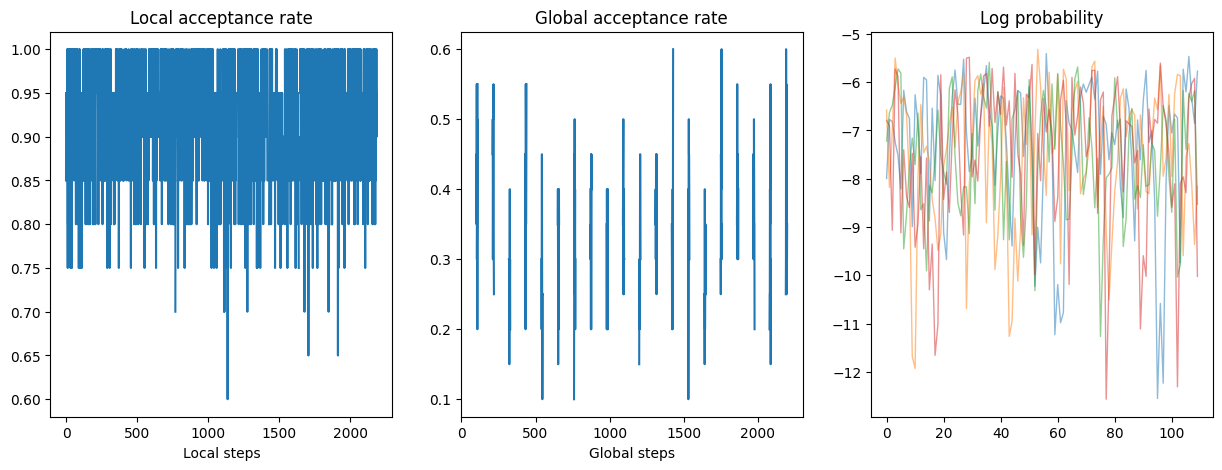

In [7]:
import numpy as np

# Get acceptance rate
local_accs = sampler.resources["local_accs_production"].data
global_accs = sampler.resources["global_accs_production"].data
log_prob = sampler.resources["log_prob_production"].data

# Mean over chains
mean_local_accs = np.mean(local_accs, axis=0)
mean_global_accs = np.mean(global_accs, axis=0)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(mean_local_accs)
ax[0].set_title("Local acceptance rate")
ax[0].set_xlabel("Local steps")
ax[1].plot(mean_global_accs)
ax[1].set_title("Global acceptance rate")
ax[1].set_xlabel("Global steps")
# We are downsampling both the chain and the step dimension for a better visualization
ax[2].plot(log_prob[::5, ::20, 0].T, lw=1, alpha=0.5)
ax[2].set_title("Log probability")

The gap you see in the global acceptance rate plot is because those are the period when the local sampler is proposing, so there is no global acceptance during those periods.

Lastly, let's look at the effective sample size (ESS) and r-hat values for the samples in the production phase.

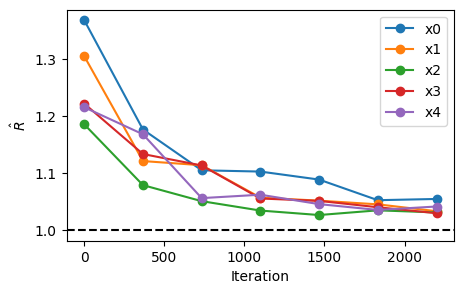

In [8]:
import arviz as az

chains = np.array(sampler.resources["positions_production"].data)
## Load data as arviz InferenceData class
n_steps = chains.shape[1]
n_step_group = 7
n_group_step = n_steps // n_step_group


rhat_s = np.array(
    [
        [
            az.rhat(chains[:, : (i + 1) * n_group_step, j], method="rank")
            for i in range(n_step_group)
        ]
        for j in range(n_dims)
    ]
)
iterations = np.linspace(0, n_steps, n_step_group)

plt.figure(figsize=(5, 3))
plt.plot(iterations, rhat_s.T, "-o", label=[f"x{i}" for i in range(n_dims)])
plt.axhline(1, c="k", ls="--")
plt.xlabel("Iteration")
plt.ylabel(r"$\hat{R}$")
plt.legend()